# Import statements

In [160]:
# Operating System
import os

#Pandas and Numpy
import pandas as pd
import numpy as np

#ramdom generator
import random

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import TransformerMixin, BaseEstimator

import category_encoders as ce
from sklearn.preprocessing import KBinsDiscretizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_curve, roc_auc_score, classification_report



#Plots
import matplotlib.pyplot as plt
%matplotlib inline

# Statistics
from scipy.stats import binom_test

# Strings
import re

# Define utility functions

In [2]:
def simple_clean(doc, regex_list=[("[\.\?\(\)\|:;_!@/*\-]", " "), (" +", " ")] ):
    
    # Make sure it is a string!
    doc = str(doc)
    
    # remove or replace characters
    for regex in regex_list:
        doc = re.sub(regex[0], regex[1], doc)
    # lowercase
    doc = doc.lower()
    # Trim
    doc = doc.strip()
    # tokenize
    #words = tokenizer.tokenize(doc)
    # remove punctuation
    #words = list(filter(lambda x: x not in string.punctuation, words))
    # stem
    #stems = list(map(stemmer.stem, words))
    #new_doc = " ".join(stems)
    new_doc = doc
    return new_doc

# Load original data

In [3]:
#file_path = ".\data\train.csv"
#file_path = os.path.join('data', 'train.csv')
file_path = os.path.join('C:\\Users\\jnpicao\\Documents\\GitHub', 'train.csv')

# Option for reading a sample of the file
# sample 20% of the rows
p = 1

random.seed(178) # this is to get always the same sample. can be removed if we want the sample to change
try:
    df_original = pd.read_csv(file_path, 
                             skiprows = lambda row_num: random.random() > p and row_num > 0, 
                             #nrows = 10000, 
                             header=0,
                             warn_bad_lines=True)
except:
    print('Ooops!!! We got an error!')
else:
    # Drop observations correspoding to stops that didn't lead to a search
    df = df_original[df_original.VehicleSearchedIndicator==True].reset_index(drop=True).drop(columns='VehicleSearchedIndicator')


# Train-Test split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='ContrabandIndicator'), 
                                                    df['ContrabandIndicator'], 
                                                    test_size=0.6, 
                                                    random_state=42)

# Pre-process 

Both the train set and the test set will enter this pre-processing to prepare for fits ans transforms:
* Select columns to keep;
* Clean text features;

In [5]:
def pre_process_data(df: pd.DataFrame) -> pd.DataFrame:
    
    """Transforms the original DataFrame to make it suited to enter the workflow.
    
    Args:
        df (pd.DataFrame):  Original DataFrame, it will be first X_train and then X_test.
        
    Returns:
        df_new (pd.DataFrame): Transformed DataFrame, ready to enter the workflow.
        
    TODO:
        * to do list
        
    """
    
    columns_to_keep = ['Department Name', 'SubjectAge']
#     columns_to_keep = ['Department Name', 
#                        'InterventionReasonCode',
#                        'ResidentIndicator', 
#                        'SearchAuthorizationCode', 
#                        'StatuteReason', 
#                        'SubjectAge', 
#                        'SubjectEthnicityCode', 
#                        'SubjectRaceCode', 
#                        'SubjectSexCode'
#                        ]
    
    # copy the argument
    df_new = df.copy()
    
    df_new = df_new[columns_to_keep]
    
    df_new['Department Name'] = df_new['Department Name'].apply(simple_clean)    
    
    return df_new

In [87]:
# Initializations

decision_thr = 0.5

ordinalencoder = ce.ordinal.OrdinalEncoder()
binarizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
clf = RandomForestClassifier(random_state = 42)


X_train_cln = pre_process_data(X_train)
X_train_cln = ordinalencoder.fit_transform(X_train_cln)
X_train_cln['SubjectAge'] = binarizer.fit_transform(X_train_cln[['SubjectAge']])
clf.fit(X_train_cln, y_train)


X_test_cln = pre_process_data(X_test)
X_test_cln = ordinalencoder.fit_transform(X_test_cln)
X_test_cln['SubjectAge'] = binarizer.fit_transform(X_test_cln[['SubjectAge']])
#y_pred = clf.predict(X_test_cln)
y_prob = clf.predict_proba(X_test_cln)[:,1]
y_pred = y_prob > decision_thr


C:\Users\jnpicao\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [60]:
clf.decision_path(X_train_cln)

(<30697x11534 sparse matrix of type '<class 'numpy.int64'>'
 	with 3583847 stored elements in Compressed Sparse Row format>,
 array([    0,  1131,  2282,  3451,  4618,  5761,  6908,  8081,  9218,
        10381, 11534], dtype=int32))

In [89]:
X_train_cln.shape

(30697, 2)

In [90]:
y_pred

array([False, False, False, ..., False,  True, False])

In [91]:
precision_score(y_test, y_pred)

0.565959952885748

In [92]:
recall_score(y_test, y_pred)

0.3123781042777272

In [93]:
accuracy_score(y_test, y_pred)

0.6902662554836468

In [162]:
fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_prob)
AUROC = roc_auc_score(y_true=y_test, y_score=y_prob)*100

In [161]:
roc_auc_score(y_true=y_test, y_score=y_prob)

0.7042873232553369

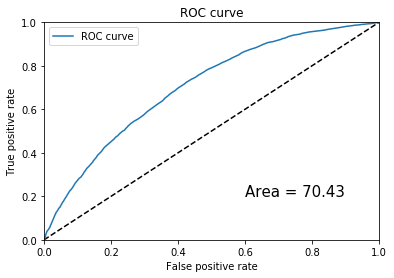

In [169]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='ROC curve')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.text(0.6, 0.2, "Area = {}".format(round(AUROC*100,2)), dict(size=15))

plt.legend(loc='best')
plt.show()

In [159]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.72      0.88      0.79     30664
        True       0.57      0.31      0.40     15382

   micro avg       0.69      0.69      0.69     46046
   macro avg       0.64      0.60      0.60     46046
weighted avg       0.67      0.69      0.66     46046



In [95]:
df_results = y_test.to_frame(name='y_true')
df_results['y_pred'] = y_pred
df_results['y_prob'] = y_prob
df_results.head()

,y_true,y_pred,y_prob
30717,False,False,0.417500
44889,True,False,0.461068
13938,False,False,0.293258
20220,False,False,0.365724
21837,True,False,0.236796


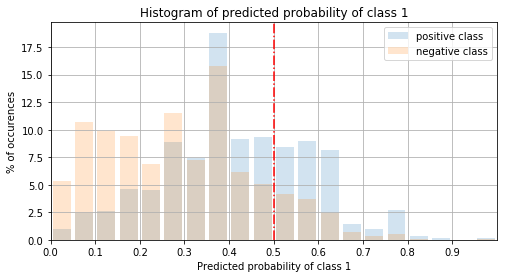

In [146]:
n_trues = df_results[df_results.y_true==True].shape[0]
n_falses = df_results[df_results.y_true==False].shape[0]

plt.figure(figsize=(8,4))
df_results[df_results.y_true==True].y_prob.hist(bins=20, weights=np.ones(n_trues)/n_trues*100, align='mid', rwidth=0.8, alpha=0.2, label='positive class')
df_results[df_results.y_true==False].y_prob.hist(bins=20, weights=np.ones(n_falses)/n_falses*100, align='mid', rwidth=0.8, alpha=0.2, label='negative class')

plt.axvline(x=decision_thr, color='r', linestyle='-.')

plt.title('Histogram of predicted probability of class 1')
plt.xlabel("Predicted probability of class 1")
plt.ylabel("% of occurences")

plt.xlim(0,1)
plt.xticks(np.arange(0, 1, step=0.1))

plt.legend();

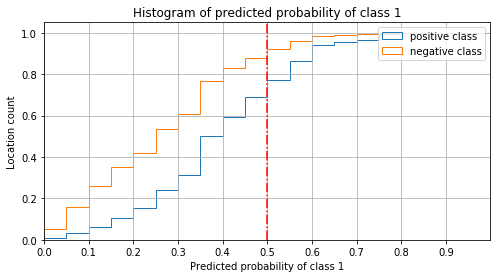

In [117]:
df_results[df_results.y_true==True].y_prob.hist(bins=20, figsize=(8,4), histtype='step',label='positive class', density=True, cumulative=True)
df_results[df_results.y_true==False].y_prob.hist(bins=20, figsize=(8,4), histtype='step', label='negative class', density=True, cumulative=True)

plt.axvline(x=decision_thr, color='r', linestyle='-.')

plt.title('Histogram of predicted probability of class 1')
plt.xlabel("Predicted probability of class 1")
plt.ylabel("Density")

plt.xlim(0,1)
plt.xticks(np.arange(0, 1, step=0.1))

plt.legend();

In [ ]:
df_results.set_index('y_prob').y_true

### Predict all `True`

In [15]:
y_pred_true = np.ones(y_test.shape).astype(bool)

In [16]:
precision_score(y_test, y_pred_true)

0.3340572471007254

In [17]:
recall_score(y_test, y_pred_true)

1.0

In [18]:
accuracy_score(y_test, y_pred_true)

0.3340572471007254

### Predict all `False`

In [19]:
y_pred_false = np.zeros(y_test.shape).astype(bool)

In [20]:
precision_score(y_test, y_pred_false)

C:\Users\jnpicao\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.0

In [21]:
recall_score(y_test, y_pred_false)

0.0

In [22]:
accuracy_score(y_test, y_pred_false)

0.6659427528992746

### Predict randomly with positive\negative ratio `r`

In [23]:
np.random.seed(425)
ratio = 0.90

In [24]:
# y_pred_rand = np.random.randint(2, size=y_test.shape).astype(bool)
y_pred_rand = np.random.binomial(n=1, p=ratio, size=y_test.shape).astype(bool)

In [25]:
y_pred_rand.sum()/y_pred_rand.shape[0]

0.9005342483603354

In [26]:
y_pred_rand.shape

(46046,)

In [27]:
precision_score(y_test, y_pred_rand)

0.3345150243573048

In [28]:
recall_score(y_test, y_pred_rand)

0.9017683006111039

In [29]:
accuracy_score(y_test, y_pred_rand)

0.36789297658862874